In [1]:
from utils import load_series_dfs
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import os
from shapely import wkt, Point
import geopandas as gpd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pickle
import requests
from utils import load_series_dfs
from config.weather_params import WeatherParam
from datetime import datetime

In [2]:
gpkg_path = os.path.join('..', 'data', 'df_mapping_centroids.gpkg')
df_mapping = gpd.read_file(gpkg_path)

df_mapping.columns

Index(['nemesys_key', 'geom_g', 'centroid_lon', 'centroid_lat', 'geometry'], dtype='object')

In [3]:
# 1. Resource-ID für stündliche Klimastationen
resource_id = 'klima-v2-1h'

# 2. Metadata-Endpoint ansprechen
url_meta  = f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}/metadata"
resp_meta = requests.get(url_meta)
resp_meta.raise_for_status()

# 3. Liste der Station-Dicts rausziehen
data = resp_meta.json()          # {'stations': [ {...}, {...}, … ]}
stations_list = data['stations']

# 4. In DataFrame umwandeln
stations_df = pd.DataFrame.from_records(stations_list)

# 5. Wichtige Spalten anzeigen
print("Spalten:", stations_df.columns.tolist())
print(stations_df[['id','name','lat','lon']].head())

Spalten: ['type', 'id', 'group_id', 'name', 'state', 'lat', 'lon', 'altitude', 'valid_from', 'valid_to', 'has_sunshine', 'has_global_radiation', 'is_active']
   id              name       lat       lon
0   1            Aflenz  47.54594  15.24069
1   2  Aigen im Ennstal  47.53278  14.13826
2   3       Allentsteig  48.69083  15.36694
3   4         Amstetten  48.10889  14.89500
4   5        Bad Aussee  47.61050  13.75844


In [4]:
df = pd.read_csv('../data/wetterdaten_top150_filled_linear.csv.gz', compression='gzip', parse_dates=['timestamp'])
df.head()

,timestamp,station_id,tl,rf,ff,ffx,cglo,so_h,rr,rrm,tb10,tb20
0,2014-01-01 00:00:00+00:00,2,-2.7,93.0,1.7,2.6,0.0,0.0,0.0,0.0,0.5,1.1
1,2014-01-01 00:00:00+00:00,7604,4.0,84.0,3.2,6.3,0.0,0.0,0.0,0.0,3.9,5.2
2,2014-01-01 00:00:00+00:00,48,1.5,88.0,0.9,2.2,0.0,0.0,0.0,0.0,3.0,3.7
3,2014-01-01 00:00:00+00:00,20412,1.4,100.0,0.2,1.5,0.0,0.0,0.0,0.0,2.8,3.2
4,2014-01-01 00:00:00+00:00,89,1.5,95.0,0.7,3.3,0.0,0.0,0.0,0.0,2.1,2.2


In [10]:
stations_df = stations_df.query('id in @df.station_id.unique()') #df.station_id.unique()

In [11]:
# Geometriedaten parsen und als GeoSeries setzen
df_mapping['geom_g'] = gpd.GeoSeries.from_wkt(df_mapping['geom_g'])

In [12]:
df_mapping = df_mapping.set_geometry('geom_g')

In [13]:
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon

def interior_point(g):
    t = g.geom_type
    if t in ("Polygon", "MultiPolygon"):
        return g.representative_point()
    elif t in ("LineString", "MultiLineString"):
        return g.interpolate(0.5, normalized=True)
    elif t == "Point":
        return g
    else:
        return g.centroid

df_mapping['pt_interior'] = df_mapping['geom_g'].apply(interior_point)

In [14]:
# Quell-CRS richtig setzen
df_mapping = df_mapping.set_crs("EPSG:32633", allow_override=True)

# In Lon/Lat transformieren
df_wgs = df_mapping.to_crs(epsg=4326)

# Lon/Lat aus dem Innen-Punkt extrahieren
df_wgs['centroid_lon'] = df_wgs['pt_interior'].x
df_wgs['centroid_lat'] = df_wgs['pt_interior'].y

In [15]:
df_wgs[['centroid_lon', 'centroid_lat']]

,centroid_lon,centroid_lat
0,574298.473492,5.236470e+06
1,592254.428411,5.234861e+06
2,451102.757675,5.278928e+06
3,459558.991970,5.339463e+06
4,456008.641067,5.342558e+06
5,438565.004915,5.351961e+06
6,484911.136354,5.181469e+06
7,454988.377977,5.327099e+06
8,178961.587808,5.264391e+06
9,626005.942156,5.302132e+06


In [16]:
import geopandas as gpd

# 1. Für alle weiteren Schritte sicherstellen, dass df_mapping das richtige CRS hat
#    (falls noch nicht geschehen)
df_mapping = df_mapping.set_crs("EPSG:32633", allow_override=True)

# 2. Neue GeoDataFrame anlegen, wobei 'pt_interior' die aktive Geometrie wird
df_pts = gpd.GeoDataFrame(
    df_mapping.drop(columns='geometry'),  # alte geometry-Spalte entfernen, falls gewünscht
    geometry=df_mapping['pt_interior'],
    crs="EPSG:32633"
)

# 3. Jetzt transformierst Du df_pts in WGS84
df_pts = df_pts.to_crs(epsg=4326)

# 4. Longitude / Latitude aus der neuen Geometrie ziehen
df_pts['centroid_lon'] = df_pts.geometry.x
df_pts['centroid_lat'] = df_pts.geometry.y

# 5. Kontrolle
print(df_pts[['nemesys_key','centroid_lon','centroid_lat']].head())

   nemesys_key  centroid_lon  centroid_lat
0  FL_00025241     15.982384     47.277499
1  FL_00352191     16.219418     47.260741
2  FL_00020896     14.348744     47.661897
3  FL_00024730     14.455680     48.207108
4  FL_00024735     14.407575     48.234712


In [17]:
df_pts[['nemesys_key','centroid_lon','centroid_lat']]

,nemesys_key,centroid_lon,centroid_lat
0,FL_00025241,15.982384,47.277499
1,FL_00352191,16.219418,47.260741
2,FL_00020896,14.348744,47.661897
3,FL_00024730,14.455680,48.207108
4,FL_00024735,14.407575,48.234712
5,FL_00352244,14.171319,48.317848
6,FL_00352430,14.802315,46.786599
7,FL_00024731,14.395472,48.095569
8,FL_00352054,10.740705,47.453774
9,FL_00352189,16.684666,47.860168


In [18]:
import numpy as np
from sklearn.neighbors import BallTree
import pandas as pd

# 1. Stations-Koordinaten in Radianten
coords_stat = np.deg2rad(stations_df[['lat','lon']].values)

# 2. Centroid-Interior-Koordinaten in Radianten
coords_map  = np.deg2rad(df_pts[['centroid_lat','centroid_lon']].values)

# 3. BallTree mit Haversine-Metrik bauen
tree = BallTree(coords_stat, metric='haversine')

# 4. Für jeden Centroid den nächsten Nachbarn suchen
dist_rad, idx = tree.query(coords_map, k=1)

# 5. In Kilometern umrechnen
dist_km = dist_rad.flatten() * 6371.0

# 6. Ergebnis-Tabelle zusammenbauen
result = pd.DataFrame({
    'nemesys_key':  df_pts['nemesys_key'].values,
    'stat_id':      stations_df.iloc[idx.flatten()]['id'].values,
    'stat_name':    stations_df.iloc[idx.flatten()]['name'].values,
    'dist_km':      dist_km
})

print(result.head())

   nemesys_key  stat_id         stat_name    dist_km
0  FL_00025241    13702         Bernstein  25.564926
1  FL_00352191    16800       Kleinzicken  10.030823
2  FL_00020896        2  Aigen im Ennstal  21.335927
3  FL_00024730       56        Linz Stadt  16.054068
4  FL_00024735       56        Linz Stadt  11.356925


In [19]:
result.stat_id.unique()

array([13702, 16800,     2,    56,    90,   204, 11402,  7710,  6102,
         141,  5972,   145,    95,   132,  2207,    91,    54,    48,
         122, 11135, 19205,  2503,  7604])

In [20]:
result.dist_km.describe()

count    43.000000
mean     15.408752
std       8.969654
min       0.845504
25%       8.531397
50%      15.194802
75%      21.317700
max      37.324077
Name: dist_km, dtype: float64

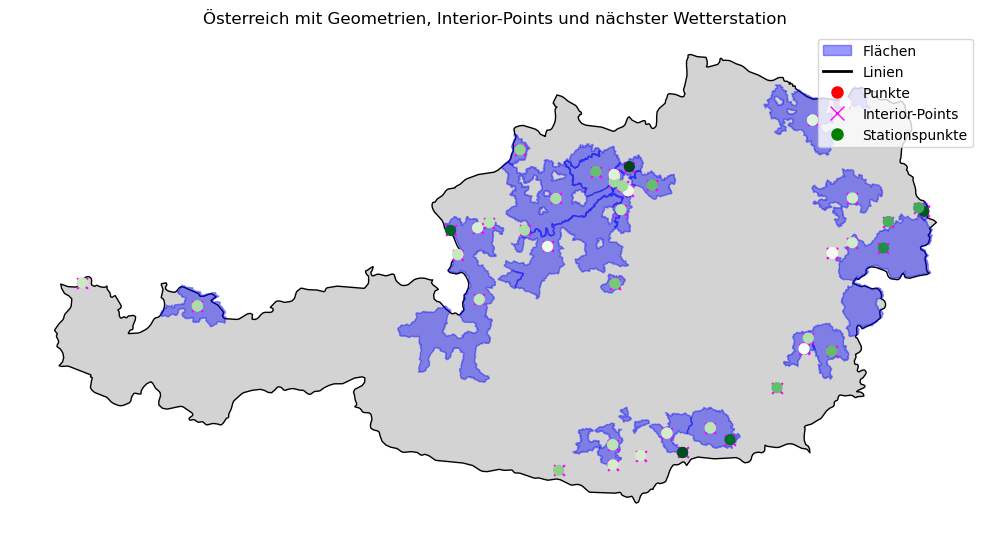

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 1. GeoDataFrame aufbauen (EPSG:32633), direkt aus geom_g
gdf = gpd.GeoDataFrame(
    df_mapping,
    geometry='geom_g',
    crs='EPSG:32633'
)

# 2. Interior-Point berechnen
gdf['pt_interior'] = gdf.geometry.apply(
    lambda geom: (
        geom.representative_point() if geom.geom_type in ("Polygon","MultiPolygon")
        else geom.interpolate(0.5, normalized=True) if geom.geom_type in ("LineString","MultiLineString")
        else geom
    )
)

# 3. Österreich-Grenze via URL laden
countries_url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
world        = gpd.read_file(countries_url)
austria      = world[world['name']=='Austria'].to_crs(gdf.crs)

# 4. Stations-GeoDataFrame erstellen und transformieren
stations_gdf = (
    gpd.GeoDataFrame(
        stations_df,
        geometry=gpd.points_from_xy(stations_df.lon, stations_df.lat),
        crs='EPSG:4326'
    )
    .to_crs(gdf.crs)
)

# 5. Nächstgelegene Station per Spatial Join (inkl. Distanz in dist_m)
pts = gpd.GeoDataFrame(gdf, geometry='pt_interior', crs=gdf.crs)
joined = gpd.sjoin_nearest(
    pts, stations_gdf,
    how='left', distance_col='dist_m'
)

# 6. Plot-Layer splitten
polygons     = gdf[gdf.geom_type.isin(['Polygon','MultiPolygon'])]
lines        = gdf[gdf.geom_type.isin(['LineString','MultiLineString'])]
points       = gdf[gdf.geom_type=='Point']
pts_interior = pts.copy()

# 7. Plot
fig, ax = plt.subplots(figsize=(10,10))
austria.plot(ax=ax, color='lightgray', edgecolor='black', zorder=0)

polygons.plot(ax=ax, facecolor='blue', edgecolor='blue', alpha=0.4, zorder=1)
lines   .plot(ax=ax, color='black', linewidth=2,       zorder=2)
points  .plot(ax=ax, color='red',   markersize=20,     zorder=3)

pts_interior.plot(
    ax=ax,
    color='magenta',
    marker='x',
    markersize=60,
    zorder=4,
    label='Interior-Points'
)

joined.plot(
    ax=ax,
    column='dist_m',         # optional: farblich nach Distanz
    cmap='Greens',           # oder einfach feste Farbe
    marker='o',
    markersize=50,
    zorder=5,
    label='Nächstgelegene Wetterstation'
)

# 8. Legende
legend_elems = [
    Patch(facecolor='blue',   edgecolor='blue',  alpha=0.4, label='Flächen'),
    Line2D([0],[0], color='black', lw=2,   label='Linien'),
    Line2D([0],[0], marker='o', color='red',   linestyle='', markersize=8,  label='Punkte'),
    Line2D([0],[0], marker='x', color='magenta', linestyle='', markersize=10, label='Interior-Points'),
    Line2D([0],[0], marker='o', color='green',   linestyle='', markersize=8,  label='Stationspunkte'),
]
ax.legend(handles=legend_elems, loc='upper right')

ax.set_title("Österreich mit Geometrien, Interior-Points und nächster Wetterstation")
ax.set_axis_off()
plt.tight_layout()
plt.show()



In [14]:
df_mapping

,nemesys_key,geom_g,centroid_lon,centroid_lat,geometry,pt_interior
0,FL_00025241,"MULTIPOLYGON (((576611.379 5233885.476, 576597...",571866.668405,5.237265e+06,POINT (574298.473 5236470.316),POINT (574298.473 5236470.316)
1,FL_00352191,"MULTIPOLYGON (((585315.47 5225725.82, 585316.0...",589874.782901,5.237858e+06,POINT (592254.428 5234861.038),POINT (592254.428 5234861.038)
2,FL_00020896,"MULTIPOLYGON (((442366.698 5277755.653, 442250...",449815.252870,5.278740e+06,POINT (451102.758 5278928.058),POINT (451102.758 5278928.058)
3,FL_00024730,"MULTIPOLYGON (((458466.08 5343618.499, 458464....",459947.407067,5.339844e+06,POINT (459558.992 5339463.043),POINT (459558.992 5339463.043)
4,FL_00024735,"MULTIPOLYGON (((455813.691 5345132.902, 455810...",456514.181913,5.342561e+06,POINT (456008.641 5342557.638),POINT (456008.641 5342557.638)
5,FL_00352244,"MULTIPOLYGON (((445856.375 5365743.919, 445856...",439780.694796,5.351455e+06,POINT (438565.005 5351960.526),POINT (438565.005 5351960.526)
6,FL_00352430,"MULTIPOLYGON (((484559.218 5193207.336, 484563...",488959.046206,5.183190e+06,POINT (484911.136 5181469.038),POINT (484911.136 5181469.038)
7,FL_00024731,"MULTIPOLYGON (((449827.988 5340014.162, 449829...",455734.427577,5.326785e+06,POINT (454988.378 5327099.089),POINT (454988.378 5327099.089)
8,FL_00352054,"MULTIPOLYGON (((168517.508 5271056.468, 168586...",179254.145161,5.263559e+06,POINT (178961.588 5264391.467),POINT (178961.588 5264391.467)
9,FL_00352189,"MULTIPOLYGON (((604720.06 5244360.402, 604761....",625275.533165,5.289817e+06,POINT (626005.942 5302132.446),POINT (626005.942 5302132.446)


In [15]:
result

,nemesys_key,stat_id,stat_name,dist_km
0,FL_00025241,13605,Hartberg,0.443725
1,FL_00352191,140,Bad Tatzmannsdorf,7.513395
2,FL_00020896,108,Windischgarsten,6.709258
3,FL_00024730,23,Enns,1.316344
4,FL_00024735,23,Enns,5.357635
5,FL_00352244,3266,Linz Petrinum,7.325624
6,FL_00352430,90,St.Andrä im Lavanttal,3.172349
7,FL_00024731,5111,Steyr Stadtgut,4.270727
8,FL_00352054,76,Reutte,4.909039
9,FL_00352189,7707,Eisenstadt,10.111299


In [17]:
series_dfs = load_series_dfs(data_dir=r"C:\Users\johannes.misensky\Documents\KI_Master\data")

In [18]:
series_dfs.keys()

dict_keys(['FL_00024702.PLAN.MengeHH', 'FL_00024730.PLAN.MengeHH', 'FL_00352243.PLAN.MengeHH', 'FL_00352244.PLAN.MengeGA', 'FL_00352244.PLAN.MengeKW', 'FL_00024360.PLAN.MengeGA', 'FL_00352254.PLAN.MengeGA', 'FL_00025248.PLAN.MengeGA', 'FL_00024360.PLAN.MengeHH.2', 'FL_00024731.PLAN.MengeHH', 'FL_00024735.PLAN.MengeHH', 'FL_00024667.PLAN.MengeHH', 'FL_00352218.PLAN.MengeHH', 'FL_00025240.PLAN.MengeHH', 'FL_00025241.PLAN.MengeHH', 'FL_00020896.PLAN.MengeHH', 'FL_00342704.PLAN.MengeGA', 'FL_00352054.PLAN.MengeHH', 'CV_00348266.PLAN.Menge', 'FL_00352254.PLAN.MengeHH', 'FL_00352244.PLAN.MengeHH', 'FL_00342704.PLAN.MengeHH', 'CV_00003083.PLAN.Menge', 'CV_00003181.PLAN.Menge', 'CV_00003192.PLAN.Menge', 'CV_00003191.PLAN.Menge', 'CV_00003183.PLAN.Menge', 'CV_00001876.PLAN.Menge', 'CV_00003094.PLAN.Menge', 'CV_00003089.PLAN.Menge', 'CV_00007270.PLAN.Menge', 'CV_00007300.PLAN.Menge', 'KN_00001613.PLAN.Menge', 'KN_00000069.PLAN.Menge', 'KN_00000067.PLAN.Menge', 'CV_00007809.PLAN.Menge', 'FL_00352

In [19]:
series_dfs['FL_00024702.PLAN.MengeHH']

,consumption,hour,weekday,month,is_weekend
von | von,,,,,
2014-01-01 06:00:00,1.472,6,2,1,0
2014-01-01 07:00:00,1.517,7,2,1,0
2014-01-01 08:00:00,1.472,8,2,1,0
2014-01-01 09:00:00,1.517,9,2,1,0
2014-01-01 10:00:00,1.495,10,2,1,0
...,...,...,...,...,...
2018-12-31 19:00:00,32.223,19,0,12,0
2018-12-31 20:00:00,29.348,20,0,12,0
2018-12-31 21:00:00,24.727,21,0,12,0


In [20]:
series_dfs['FL_00024702.PLAN.MengeHH'].index.max()

Timestamp('2018-12-31 23:00:00')

In [21]:
resource_id   = 'klima-v2-1h'
weather_params = WeatherParam.keys()
start_iso = '2014-01-01T06:00:00Z'
end_iso   = '2018-12-31T23:00:00Z'

# Optional: falls ein API-Token benötigt wird, hier einfügen:
# headers = {'Authorization': 'Bearer YOUR_TOKEN_HERE'}
headers = {}

# 1. Ergebnis-DF: map nemesys_key -> stat_id
#    Erwartet result DataFrame mit Spalten ['nemesys_key','stat_id']
stat_map = result.set_index('nemesys_key')['stat_id'].to_dict()

In [38]:
import requests
import pandas as pd

# 1. Parameter definieren
resource_id    = 'klima-v2-1h'
station_id     = 140
weather_params = ['tl','rf','ff','ffx','cglo','so_h','rr','rrm','tb10','tb20']
start_iso      = '2018-01-01T00:00'
end_iso        = '2018-01-31T23:00'

# 2. URL zusammenbauen (Kommas UNESCAPED!)
param_str = ','.join(weather_params)
url = (
    f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}"
    f"?station_ids={station_id}"
    f"&parameters={param_str}"
    f"&start={start_iso}"
    f"&end={end_iso}"
    f"&format=json"
)

# 3. Anfrage und Fehlercheck
resp = requests.get(url)
resp.raise_for_status()
fc = resp.json()

# 4. Zeiten und Feature-Daten extrahieren
timestamps = pd.to_datetime(fc['timestamps'])                    # Liste aller Zeitpunkte
feat       = fc['features'][0]                                   # nur eine Station erwartet
params     = feat['properties']['parameters']                    # dict mit jedem Parameter

# 5. DataFrame aufbauen
df_weather = pd.DataFrame(
    { p: params[p]['data'] for p in weather_params if p in params },
    index=timestamps
)

# 6. Überprüfen
df_weather.head()


,tl,rf,ff,ffx,cglo,so_h,rr,rrm,tb10,tb20
2018-01-01 00:00:00+00:00,-2.1,92,0.0,0.9,None,0.0,0.0,0,None,None
2018-01-01 01:00:00+00:00,-1.9,94,0.5,1.6,None,0.0,0.0,0,None,None
2018-01-01 02:00:00+00:00,-2.1,93,0.0,0.9,None,0.0,0.0,0,None,None
2018-01-01 03:00:00+00:00,-1.8,94,0.4,1.8,None,0.0,0.0,0,None,None
2018-01-01 04:00:00+00:00,-1.0,94,0.8,2.0,None,0.0,0.0,0,None,None


In [23]:
import requests
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
import logging

def fetch_weather_df(
    station_id: int,
    weather_params: List[str],
    resource_id: str,
    start_iso: str,
    end_iso: str,
    headers: Optional[Dict[str,str]] = None
) -> pd.DataFrame:
    """
    Holt die JSON-Daten von Geosphere und baut ein DataFrame mit Index=Timestamps (ohne tz)
    und genau den Spalten weather_params (fehlende werden mit NaN aufgefüllt).
    """
    logging.info(f"Fetching weather data for station {station_id}...")
    url = f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}"
    params = {
        'station_ids': station_id,
        'parameters': ','.join(weather_params),
        'start': start_iso,
        'end': end_iso,
        'format': 'json'
    }
    resp = requests.get(url, params=params, headers=headers)
    resp.raise_for_status()
    fc = resp.json()
    # 1) Zeitstempel
    timestamps = pd.to_datetime(fc['timestamps'])
    # 2) Properties
    props = fc['features'][0]['properties']['parameters']
    # 3) DataFrame aufbauen
    data = {
        p: np.array(props[p]['data'], dtype=float)
        for p in weather_params
        if p in props
    }
    df = pd.DataFrame(data, index=timestamps)
    # 4) fehlende Spalten hinzufügen
    for p in weather_params:
        if p not in df.columns:
            df[p] = np.nan
    # 5) Zeitzone entfernen, wenn vorhanden
    if df.index.tz is not None:
        df.index = df.index.tz_convert(None)
    return df[weather_params]


def merge_all_series_with_weather(
    series_dfs: Dict[str, pd.DataFrame],
    stat_map: Dict[str, int],
    weather_params: List[str],
    resource_id: str,
    start_iso: str,
    end_iso: str,
    headers: Optional[Dict[str,str]] = None
) -> Tuple[
    Dict[str, pd.DataFrame],
    List[str],
    List[Tuple[str,int,List[str]]]
]:
    """
    Merged jede Verbrauchs-Serie mit den zugehörigen Wetterdaten.
    Liefert:
      - merged_series[nemesys] = merged DataFrame
      - no_station = Liste der nemesys-Keys ohne Station
      - incomplete = Liste von (nemesys, station_id, [fehlende_parameter])
    """
    merged_series = {}
    no_station = []
    incomplete = []

    for series_key, cons_df in series_dfs.items():
        nemesys = series_key.split('.')[0]
        station_id = stat_map.get(nemesys)
        if station_id is None:
            no_station.append(nemesys)
            continue

        # Wetter-DF holen
        weather_df = fetch_weather_df(
            station_id, weather_params,
            resource_id, start_iso, end_iso,
            headers=headers
        )

        # Merge auf Zeitindex
        merged = cons_df.merge(
            weather_df,
            left_index=True, right_index=True,
            how='left',
            suffixes=('', '_weather')
        )

        # Fehlende-Flags
        for p in weather_params:
            merged[f'missing_{p}'] = merged[p].isna()

        # Prüfen, ob die Station wirklich alle Parameter liefern konnte
        missing = [p for p in weather_params
                   if weather_df[p].isna().all()]
        if missing:
            incomplete.append((nemesys, station_id, missing))

        merged_series[nemesys] = merged

    return merged_series, no_station, incomplete



In [24]:
weather_params = WeatherParam.keys()
stat_map = result.set_index('nemesys_key')['stat_id'].to_dict()
merged_series, no_station, incomplete = merge_all_series_with_weather(
    series_dfs=series_dfs,
    stat_map=stat_map,
    weather_params=weather_params,
    resource_id='klima-v2-1h',
    start_iso='2018-01-01T00:00',
    end_iso='2018-01-31T23:00',
    headers=None
)
print("Keine Station gefunden für:", no_station)
print("Unvollständige Parameter bei:", incomplete)

Keine Station gefunden für: []
Unvollständige Parameter bei: [('FL_00024702', 3257, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00024730', 23, ['tb10', 'tb20']), ('FL_00352243', 3400, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00352244', 3266, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00352244', 3266, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00024360', 5916, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00352254', 4800, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00024360', 5916, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00024731', 5111, ['tl', 'rf', 'ff', 'ffx', 'cglo', 'so_h', 'rr', 'rrm', 'tb10', 'tb20']), ('FL_00024735', 23, ['tb10', 'tb20']), ('FL_00024667', 2910, ['tb10', 'tb20']), ('FL_00352218', 9406, ['tb10', 'tb20']), ('FL_00025240', 11

In [30]:
len(stat_map.keys())

43

In [28]:
len(merged_series.keys())

43

In [39]:
merged_series['KN_00000069']

,consumption,hour,weekday,month,is_weekend,tl,rf,ff,ffx,cglo,...,missing_tl,missing_rf,missing_ff,missing_ffx,missing_cglo,missing_so_h,missing_rr,missing_rrm,missing_tb10,missing_tb20
2014-01-01 06:00:00,1.650,6,2,1,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
2014-01-01 07:00:00,1.738,7,2,1,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
2014-01-01 08:00:00,1.638,8,2,1,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
2014-01-01 09:00:00,1.495,9,2,1,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
2014-01-01 10:00:00,1.431,10,2,1,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,1.156,19,0,12,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
2018-12-31 20:00:00,1.186,20,0,12,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
2018-12-31 21:00:00,1.102,21,0,12,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True
2018-12-31 22:00:00,0.882,22,0,12,0,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,True,True,True,True,True,True


In [37]:
# 2. Container für die gemergten DataFrames
merged_series = {}

# 3. Durch alle Serien iterieren
for series_key, cons_df in series_dfs.items():
    # a) nemesys_key extrahieren
    nemesys = series_key.split('.')[0]
    # b) passende Station finden
    stat_id = stat_map.get(nemesys)
    if stat_id is None:
        print(f"⚠️ Keine Station für {nemesys} gefunden, übersprungen.")
        continue

    # c) Wetterdaten abrufen
    url = f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}"
    params = {
    'station_ids': stat_id,
    'parameters' : ','.join(p.upper() for p in weather_params),
    'start'      : start_iso,   # z.B. '2014-01-01T06:00:00Z'
    'end'        : end_iso,     # z.B. '2018-12-31T23:00:00Z'
    'format'     : 'json'
    }
    resp = requests.get(url, params=params, headers=headers)
    resp.raise_for_status()
    data = resp.json().get('data', [])

    # d) In DataFrame umwandeln
    if not data:
        print(f"⚠️ Keine Wetterdaten für Station {stat_id} ({nemesys}).")
        weather_df = pd.DataFrame(columns=weather_params)
    else:
        print(f"Wetterdaten für Station {stat_id} ({nemesys}).")
        weather_df = pd.DataFrame.from_records(data)
        # JSON liefert typischerweise: [{ 'timestamp':'2014-01-01T06:00:00Z', 'tl':..., …}, …]
        weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
        weather_df = weather_df.set_index('timestamp')[weather_params]

    # e) Merge mit Verbrauch (stündlich, index = Zeitstempel)
    merged = cons_df.merge(
        weather_df,
        left_index=True,
        right_index=True,
        how='left',
        suffixes=('', '_weather')
    )

    # f) Flags für fehlende Parameter setzen
    for p in weather_params:
        flag_col = f'missing_{p}'
        merged[flag_col] = merged[p].isna()

    # g) Optional: prüfen, ob Station überhaupt alle Parameter abdeckt
    missing_overall = {p: weather_df[p].isna().any() or p not in weather_df.columns
                       for p in weather_params}
    if any(missing_overall.values()):
        print(f"⚠️ Station {stat_id} ({nemesys}) unvollständige Parameter:",
              {p: missing for p, missing in missing_overall.items() if missing})

    # h) Ergebnis speichern
    merged_series[nemesys] = merged

⚠️ Keine Wetterdaten für Station 3257 (FL_00024702).
⚠️ Keine Wetterdaten für Station 23 (FL_00024730).
⚠️ Keine Wetterdaten für Station 3400 (FL_00352243).
⚠️ Keine Wetterdaten für Station 3266 (FL_00352244).
⚠️ Keine Wetterdaten für Station 3266 (FL_00352244).
⚠️ Keine Wetterdaten für Station 5916 (FL_00024360).
⚠️ Keine Wetterdaten für Station 4800 (FL_00352254).
⚠️ Keine Wetterdaten für Station 2207 (FL_00025248).
⚠️ Keine Wetterdaten für Station 5916 (FL_00024360).
⚠️ Keine Wetterdaten für Station 5111 (FL_00024731).
⚠️ Keine Wetterdaten für Station 23 (FL_00024735).
⚠️ Keine Wetterdaten für Station 2910 (FL_00024667).
⚠️ Keine Wetterdaten für Station 9406 (FL_00352218).
⚠️ Keine Wetterdaten für Station 116 (FL_00025240).
⚠️ Keine Wetterdaten für Station 13605 (FL_00025241).
⚠️ Keine Wetterdaten für Station 108 (FL_00020896).
⚠️ Keine Wetterdaten für Station 6621 (FL_00342704).
⚠️ Keine Wetterdaten für Station 76 (FL_00352054).
⚠️ Keine Wetterdaten für Station 6630 (CV_00348266).


KeyboardInterrupt: 

In [38]:
# Verfügbarkeitszeiträume zusammenführen
df_periods = pd.merge(
    result[['nemesys_key','stat_id']],
    stations_df[['id','name','valid_from','valid_to']],
    left_on='stat_id', right_on='id', how='left'
)
df_periods['valid_from'] = pd.to_datetime(df_periods['valid_from'])
df_periods['valid_to']   = pd.to_datetime(df_periods['valid_to'])

# 3a. einfache Jupyter-Ansicht
display(df_periods[['nemesys_key','stat_id','name','valid_from','valid_to']])

# 3b. oder als Markdown-Tabelle ausgeben
print(df_periods[['nemesys_key','stat_id','name','valid_from','valid_to']]
      .to_markdown(index=False))

,nemesys_key,stat_id,name,valid_from,valid_to
0,FL_00025241,13605,Hartberg,1994-06-01 00:00:00+00:00,2100-12-31 00:00:00+00:00
1,FL_00352191,140,Bad Tatzmannsdorf,2004-09-17 00:00:00+00:00,2100-12-31 00:00:00+00:00
2,FL_00020896,108,Windischgarsten,1983-10-07 00:00:00+00:00,2100-12-31 00:00:00+00:00
3,FL_00024730,23,Enns,1948-01-01 00:00:00+00:00,2100-12-31 00:00:00+00:00
4,FL_00024735,23,Enns,1948-01-01 00:00:00+00:00,2100-12-31 00:00:00+00:00
5,FL_00352244,3266,Linz Petrinum,1932-10-14 00:00:00+00:00,1938-07-31 23:00:00+00:00
6,FL_00352430,90,St.Andrä im Lavanttal,1993-03-11 00:00:00+00:00,2100-12-31 00:00:00+00:00
7,FL_00024731,5111,Steyr Stadtgut,1956-01-01 00:00:00+00:00,1984-10-31 23:00:00+00:00
8,FL_00352054,76,Reutte,1994-08-01 00:00:00+00:00,2100-12-31 00:00:00+00:00
9,FL_00352189,7707,Eisenstadt,1981-02-01 00:00:00+00:00,1992-01-31 23:00:00+00:00


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [39]:
# Test-Parameter
resource_id = 'klima-v2-1h'
test_stat   = 13605  # Beispiel: Hartberg
weather_params = ['tl','rf','ff','ffx','cglo','so_h','rr','rrm','tb10','tb20']
start_iso  = '2014-01-01T06:00:00Z'
end_iso    = '2018-12-31T23:00:00Z'

# URL und Parameter
url = f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}"
params = {
    'station_ids': test_stat,
    'parameters' : ','.join(p.upper() for p in weather_params),
    'start'      : start_iso,
    'end'        : end_iso,
    'format'     : 'json'
}

# Anfrage senden
resp = requests.get(url, params=params)
print("HTTP-Status:", resp.status_code)
print("Request-URL:", resp.url)

# Ergebnis auswerten
resp.raise_for_status()
payload = resp.json()
data = payload.get('data', [])
print(f"Anzahl Datensätze zurück:", len(data))

# Falls Daten da sind, in DataFrame umwandeln und anzeigen
if data:
    df_test = pd.DataFrame.from_records(data)
    df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
    df_test = df_test.set_index('timestamp')
    print(df_test.head())
else:
    print("⚠️ Keine Daten gefunden.")

HTTP-Status: 200
Request-URL: https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h?station_ids=13605&parameters=TL%2CRF%2CFF%2CFFX%2CCGLO%2CSO_H%2CRR%2CRRM%2CTB10%2CTB20&start=2014-01-01T06%3A00%3A00Z&end=2018-12-31T23%3A00%3A00Z&format=json
Anzahl Datensätze zurück: 0
⚠️ Keine Daten gefunden.


In [41]:
import json
url_meta = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h/metadata"
resp     = requests.get(url_meta)
resp.raise_for_status()
meta     = resp.json()

# Welche Top-Level-Keys liefert das Meta-Objekt?
print("Meta-Keys:", meta.keys())

# Und unter 'parameters' (oder wie es heißt) findest du Name/Unit etc.
print(json.dumps(meta.get('parameters', meta.get('vars', [])), indent=2))

Meta-Keys: dict_keys(['stations', 'parameters', 'title', 'frequency', 'type', 'mode', 'response_formats', 'start_time', 'end_time', 'id_type'])
[
  {
    "name": "cglo",
    "long_name": "Globalstrahlung Mittelwert",
    "description": "Globalstrahlung, kalibrierter Stunden-Mittelwert",
    "unit": "W/m\u00b2"
  },
  {
    "name": "cglo_flag",
    "long_name": "Qualit\u00e4tsflag f\u00fcr Globalstrahlung Mittelwert",
    "description": "Qualit\u00e4tsflag f\u00fcr Globalstrahlung, kalibrierter Stunden-Mittelwert - Codeliste={None: 'undefiniert', 0: 'ungepr\u00fcfte Daten', 10: 'automatisch gepr\u00fcft', 11: 'automatisch gepr\u00fcft (ver\u00e4ndert)', 12: 'automatisch gepr\u00fcft (original)', 20: 'manuell gepr\u00fcft (unbekannt)', 21: 'manuell gepr\u00fcft (ver\u00e4ndert)', 22: 'manuell gepr\u00fcft (original)'}",
    "unit": "code",
    "code_list": [
      {
        "key": null,
        "value": "undefiniert"
      },
      {
        "key": 0,
        "value": "ungepr\u00fcfte Da

In [42]:

url_meta = "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h/metadata"
resp     = requests.get(url_meta)
resp.raise_for_status()
meta     = resp.json()

print("Dataset verfügbar von", meta['start_time'], "bis", meta['end_time'])

Dataset verfügbar von 1880-04-01T00:00:00+00:00 bis 2025-05-16T13:00:00


In [70]:
test_params = {
    'station_ids': 13605,
    'parameters' : 'tl,rf,ff',
    'start'      : '2018-01-01T00:00:00Z',
    'end'        : '2018-01-31T23:00:00Z',
    'format'     : 'json'
}
resp = requests.get(
    "https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h",
    params=test_params
)
print(resp.status_code, resp.url)
print("Datensätze:", len(resp.json().get('data', [])))

200 https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h?station_ids=13605&parameters=tl%2Crf%2Cff&start=2018-01-01T00%3A00%3A00Z&end=2018-01-31T23%3A00%3A00Z&format=json
Datensätze: 0


In [47]:
resource_id = 'klima-v2-1h'
start_iso   = '2018-01-01T00:00+00:00'   # <- Sekundenteil weggelassen!
end_iso     = '2018-01-31T23:00+00:00'

params = {
    'station_ids': 1,          # Aflenz
    'parameters' : 'tl',       # nur Lufttemp
    'start'      : start_iso,
    'end'        : end_iso,
    'format'     : 'json'
}

resp = requests.get(
    f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}",
    params=params
)
print("HTTP-Status:", resp.status_code)
print("Request-URL:", resp.url)

# Fehlermeldungen ausliefern, falls vorhanden
try:
    resp.raise_for_status()
except requests.HTTPError:
    print("API-Fehler-Antwort:", resp.text)
    raise

data = resp.json().get('data', [])
print("Datensätze:", len(data))

if data:
    df = pd.DataFrame.from_records(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    print(df[['tl']].head())
else:
    print("→ immer noch keine Daten — dann stimmt wirklich etwas Anderes nicht.")

HTTP-Status: 200
Request-URL: https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h?station_ids=1&parameters=tl&start=2018-01-01T00%3A00%2B00%3A00&end=2018-01-31T23%3A00%2B00%3A00&format=json
Datensätze: 0
→ immer noch keine Daten — dann stimmt wirklich etwas Anderes nicht.


In [52]:
import requests, pandas as pd

resource_id = 'klima-v2-1h'
params = {
    'station_ids': 1,                  # z.B. Aflenz
    'parameters' : 'tl,rf,ff',
    'start'      : '2020-05-01T00:00+00:00',
    'end'        : '2020-05-16T13:00+00:00',
    'format'     : 'json'
}

resp = requests.get(
    f"https://dataset.api.hub.geosphere.at/v1/station/historical/{resource_id}",
    params=params
)
print("Status:", resp.status_code)
print("URL:   ", resp.url)

data = resp.json().get('data', [])
print("Datensätze:", len(data))
if data:
    df = pd.DataFrame.from_records(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    print(df[['tl','rf','ff']].head())
else:
    print("→ Kein stationärer Messwert für diesen Zeitraum gefunden.")

Status: 200
URL:    https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h?station_ids=1&parameters=tl%2Crf%2Cff&start=2020-05-01T00%3A00%2B00%3A00&end=2020-05-16T13%3A00%2B00%3A00&format=json
Datensätze: 0
→ Kein stationärer Messwert für diesen Zeitraum gefunden.


In [64]:
resource_id    = 'inca-v1-1h-1km'
lat            = df_pts.loc[0, 'centroid_lat']
lon            = df_pts.loc[0, 'centroid_lon']
weather_params = ['tl','rf','ff','ffx','cglo','so_h','rr','rrm','tb10','tb20']
start_iso      = '2014-01-01T06:00+00:00'
end_iso        = '2018-12-31T23:00+00:00'

# 2. Grid-Endpoint verwenden
url = f"https://dataset.api.hub.geosphere.at/v1/grid/historical/{resource_id}"
params = {
    'lat_lon'   : f"{lat},{lon}",                     # "47.27,15.98"
    'parameters': ','.join(weather_params),            # tl,rf,ff,...
    'start'     : start_iso,
    'end'       : end_iso,
    'format'    : 'json'
}

# 3. Request absenden
resp = requests.get(url, params=params)
print("HTTP-Status:", resp.status_code)
print("Request-URL:", resp.url)
resp.raise_for_status()

# 4. Daten prüfen
data = resp.json().get('data', [])
print("Anzahl Zeilen:", len(data))
if not data:
    print("⚠️ Keine Daten zurück – das wäre ungewöhnlich für ein vollständiges Grid-Dataset.")
else:
    df_grid = pd.DataFrame.from_records(data)
    df_grid['timestamp'] = pd.to_datetime(df_grid['timestamp'])
    df_grid = df_grid.set_index('timestamp')
    print(df_grid.head())

HTTP-Status: 422
Request-URL: https://dataset.api.hub.geosphere.at/v1/grid/historical/inca-v1-1h-1km?lat_lon=47.27749934136746%2C15.982384282840464&parameters=tl%2Crf%2Cff%2Cffx%2Ccglo%2Cso_h%2Crr%2Crrm%2Ctb10%2Ctb20&start=2014-01-01T06%3A00%2B00%3A00&end=2018-12-31T23%3A00%2B00%3A00&format=json


HTTPError: 422 Client Error: Unprocessable Entity for url: https://dataset.api.hub.geosphere.at/v1/grid/historical/inca-v1-1h-1km?lat_lon=47.27749934136746%2C15.982384282840464&parameters=tl%2Crf%2Cff%2Cffx%2Ccglo%2Cso_h%2Crr%2Crrm%2Ctb10%2Ctb20&start=2014-01-01T06%3A00%2B00%3A00&end=2018-12-31T23%3A00%2B00%3A00&format=json

In [62]:
def get_stations(session):
    response = session.get(
        "https://dataset.api.hub.zamg.ac.at/v1/station/{mode}/klima-v1-10min/filter?start_date=2013-01-01&end_date=2013-01-01&has_sunshine=true&is_active=true")
    df = pd.DataFrame.from_dict(response.json()['matching_stations'])
    return df


s = requests.session()
df_stations = get_stations(s)

np.float64(47.27749934136746)

In [68]:
import requests
import pandas as pd

resource_id    = 'inca-v1-1h-1km'
weather_params = ['tl','rf','ff','ffx','cglo','so_h','rr','rrm','tb10','tb20']
start_iso      = '2014-01-01T06:00+00:00'
end_iso        = '2018-12-31T23:00+00:00'

# 1. Innen-Centroid in WGS84-Grad extrahieren
lat = df_pts.loc[0, 'centroid_lat']
lon = df_pts.loc[0, 'centroid_lon']

# 2. bbox so festlegen, dass es exakt euren Punkt umschließt
bbox = f"{lat},{lon},{lat},{lon}"  # south,west,north,east

url = f"https://dataset.api.hub.geosphere.at/v1/grid/historical/{resource_id}"
params = {
    'bbox'      : bbox,
    'parameters': ','.join(weather_params),
    'start'     : start_iso,
    'end'       : end_iso,
    'format'    : 'json'
}

resp = requests.get(url, params=params)
print("HTTP-Status:", resp.status_code)
print("URL zum Testen:", resp.url)
resp.raise_for_status()

data = resp.json().get('data', [])
print("Anzahl Zeilen:", len(data))

if data:
    df_grid = pd.DataFrame.from_records(data)
    df_grid['timestamp'] = pd.to_datetime(df_grid['timestamp'])
    df_grid = df_grid.set_index('timestamp')
    print(df_grid.head())
else:
    print("⚠️ Immer noch keine Daten? Dann stimmt etwas anderes nicht.")

HTTP-Status: 400
URL zum Testen: https://dataset.api.hub.geosphere.at/v1/grid/historical/inca-v1-1h-1km?bbox=47.27749934136746%2C15.982384282840464%2C47.27749934136746%2C15.982384282840464&parameters=tl%2Crf%2Cff%2Cffx%2Ccglo%2Cso_h%2Crr%2Crrm%2Ctb10%2Ctb20&start=2014-01-01T06%3A00%2B00%3A00&end=2018-12-31T23%3A00%2B00%3A00&format=json


HTTPError: 400 Client Error: Bad Request for url: https://dataset.api.hub.geosphere.at/v1/grid/historical/inca-v1-1h-1km?bbox=47.27749934136746%2C15.982384282840464%2C47.27749934136746%2C15.982384282840464&parameters=tl%2Crf%2Cff%2Cffx%2Ccglo%2Cso_h%2Crr%2Crrm%2Ctb10%2Ctb20&start=2014-01-01T06%3A00%2B00%3A00&end=2018-12-31T23%3A00%2B00%3A00&format=json

In [73]:
# --- 1) Basis-Infos -------------------------------------------------
BASE_URL    = "https://dataset.api.hub.geosphere.at/v1"
RESOURCE_ID = "klima-v2-1h"        # Messstationen Stundendaten v2 :contentReference[oaicite:6]{index=6}
station_id  = "13605"
# vollständiges RFC3339-Format mit Sekunden
start_iso   = "2018-01-01T00:00:00+00:00"
end_iso     = "2018-01-31T23:00:00+00:00"

# --- 2) Metadaten abrufen --------------------------------------------
meta_url = f"{BASE_URL}/station/historical/{RESOURCE_ID}/metadata"
resp_meta = requests.get(meta_url)
resp_meta.raise_for_status()
meta_json = resp_meta.json()       # liefert u.a. 'parameters' (Liste) :contentReference[oaicite:7]{index=7}

# Parameterliste extrahieren (Namen und Flags)
parameter_list = [
    p.get("name") or p.get("parameter")
    for p in meta_json["parameters"]
]

# --- 3) Daten abfragen ------------------------------------------------
data_url = f"{BASE_URL}/station/historical/{RESOURCE_ID}"
params = {
    "station_ids": station_id,
    "start_iso":    start_iso,
    "end_iso":      end_iso,
    "parameters":   ",".join(parameter_list),
}

resp_data = requests.get(data_url, params=params)
if resp_data.status_code != 200:
    # Debugging: Fehlertext anzeigen, bevor Exception geworfen wird
    print(f"Status Code: {resp_data.status_code}")
    print("Antwort des Servers:", resp_data.text)
resp_data.raise_for_status()      # löst bei Fehler einen HTTPError aus

# --- 4) In pandas DataFrame umwandeln -------------------------------
data_json = resp_data.json()
obs = data_json["observations"]
df = pd.DataFrame(obs)

# --- 5) Zeitspalte konvertieren und als Index setzen -----------------
time_col = "time" if "time" in df.columns else "datum"
df[time_col] = pd.to_datetime(df[time_col])
df.set_index(time_col, inplace=True)

print(df.head())

Status Code: 422
Antwort des Servers: {"detail":[{"loc":["query","start"],"msg":"field required","type":"value_error.missing"},{"loc":["query","end"],"msg":"field required","type":"value_error.missing"}]}


HTTPError: 422 Client Error: Unprocessable Entity for url: https://dataset.api.hub.geosphere.at/v1/station/historical/klima-v2-1h?station_ids=13605&start_iso=2018-01-01T00%3A00%3A00%2B00%3A00&end_iso=2018-01-31T23%3A00%3A00%2B00%3A00&parameters=cglo%2Ccglo_flag%2Cdd%2Cdd_flag%2Cddx%2Cddx_flag%2Cff%2Cff_flag%2Cffx%2Cffx_flag%2Cp%2Cp_flag%2Crf%2Crf_flag%2Crr%2Crr_flag%2Crrm%2Crrm_flag%2Csh%2Csh_flag%2Cso_h%2Cso_h_flag%2Ctb10%2Ctb100%2Ctb100_flag%2Ctb10_flag%2Ctb20%2Ctb200%2Ctb200_flag%2Ctb20_flag%2Ctb50%2Ctb50_flag%2Ctl%2Ctl_flag%2Ctsmin%2Ctsmin_flag%2Czeitx%2Czeitx_flag